In [1]:
import numpy as np
import pandas as pd
import warnings

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(threshold=10000, suppress = True)
warnings.filterwarnings('ignore')

df = pd.read_csv('data/KDDCup99.csv')
df['target'] = (df['target'] != 'normal').astype(int)

### Préparation des données :
Les données sont déséquilibrées

Text(0, 0.5, 'Nombre')

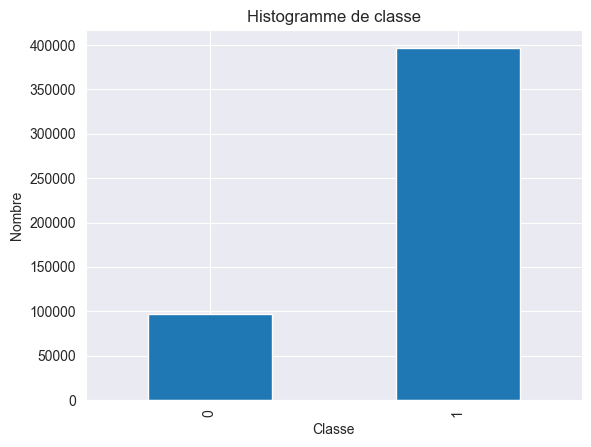

In [2]:
count_classes = pd.value_counts(df['target'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Histogramme de classe")
plt.xlabel("Classe")
plt.ylabel("Nombre")

### Équilibrage des données : 

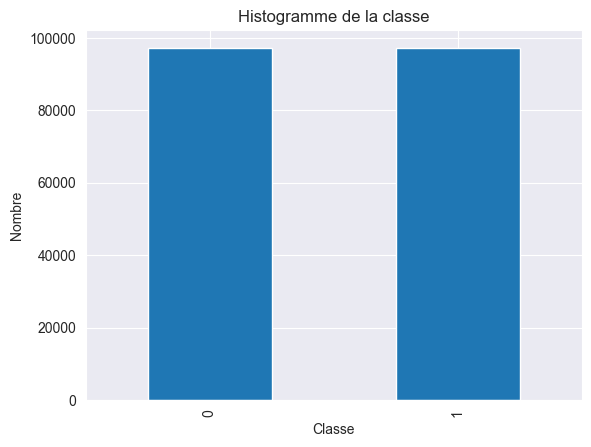

In [3]:
# Nombre d'instances de la classe "normal" (target == 0)
number_normal = len(df[df.target == 0])

# Indices des instances "normal"
normal_indices = np.array(df[df.target == 0].index)

# Indices des instances de la classe cible (target == 1)
other_indices = df[df.target == 1].index

# Sous-échantillonner les indices des autres classes
random_other_indices = np.random.choice(other_indices, number_normal, replace=False)
random_other_indices = np.array(random_other_indices)

# Combiner les indices sous-échantillonnés
under_sample_indices = np.concatenate([normal_indices, random_other_indices])

# Créer le DataFrame sous-échantillonné
under_sample_data = df.iloc[under_sample_indices, :]

# Vérification de la distribution des classes
count_classes = pd.value_counts(under_sample_data['target'], sort=True).sort_index()

# Afficher l'histogramme de la distribution
count_classes.plot(kind='bar')
plt.title("Histogramme de la classe")
plt.xlabel("Classe")
plt.ylabel("Nombre")
plt.show()

In [4]:
df = under_sample_data.sample(frac=1, random_state=4).reset_index(drop=True).head(30000)

### Identification des données catégorielles

In [5]:
numeric_cols = df._get_numeric_data().columns # gets all the numeric column names
categorical_cols = list(set(df.columns)-set(numeric_cols))
print("Colonnes catégorielles : ", categorical_cols)

Colonnes catégorielles :  ['flag', 'protocol_type', 'service']


In [6]:
binary_cols = []
for col in numeric_cols:
  if len(df[col].unique()) <= 2:
      binary_cols.append(col)
binary_cols.remove('target')
print("Colonnes binaires : ", binary_cols)

Colonnes binaires :  ['land', 'urgent', 'num_failed_logins', 'logged_in', 'lroot_shell', 'lsu_attempted', 'lnum_shells', 'lnum_outbound_cmds', 'is_host_login', 'is_guest_login']


In [7]:
for col in binary_cols:
  categorical_cols.append(col)

___

Visualisons les données : 

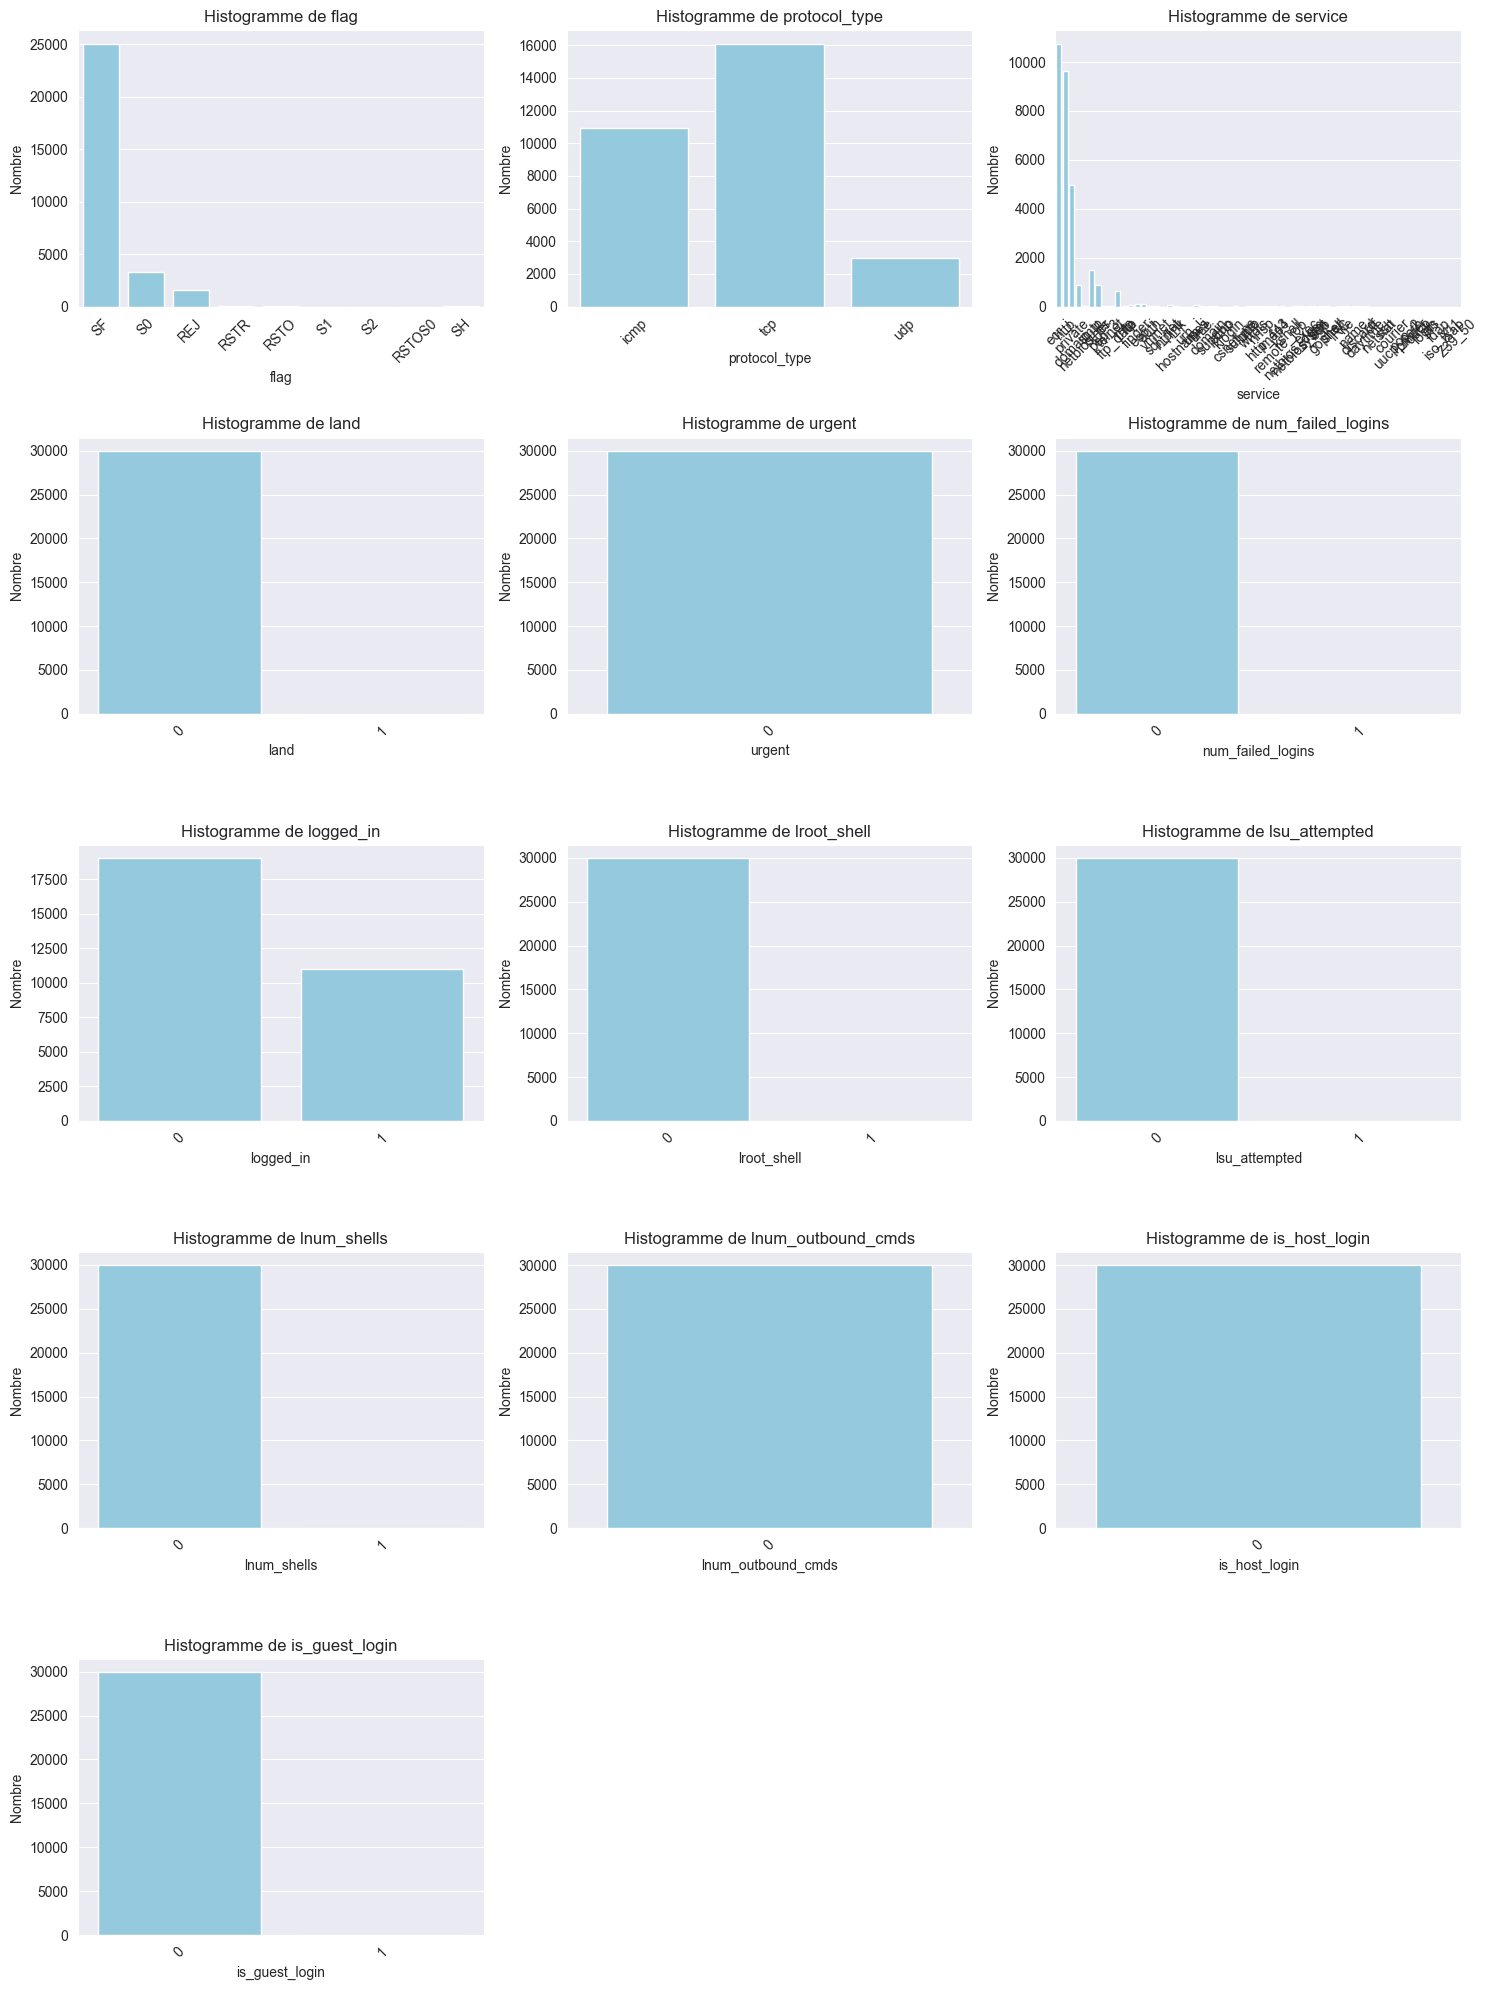

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

n_cols = 3
n_rows = (len(categorical_cols) + n_cols - 1) // n_cols  # Calculer le nombre de lignes nécessaires

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()  # Aplatir les axes pour une itération facile

for i, col in enumerate(categorical_cols):
    sns.countplot(data=df, x=col, color='skyblue', ax=axes[i])  # Tracer sur le bon axe
    axes[i].set_title(f"Histogramme de {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Nombre")
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

On peut retirer les données inutiles :

In [9]:
to_remove = []
for col in categorical_cols:
    if df[col].nunique() == 1:
        to_remove.append(col)
for col in to_remove:
    categorical_cols.remove(col)
print("Colonnes que l'on peut retirer :", to_remove)
df.drop(to_remove, axis=1, inplace=True)

Colonnes que l'on peut retirer : ['urgent', 'lnum_outbound_cmds', 'is_host_login']


---

### Encodage OneHot des données catégorielles : 

In [10]:
X = df.drop('target', axis=1)
y = df['target']
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

onehot_encoder = OneHotEncoder(sparse_output=False, drop=None)
encoded_cols = onehot_encoder.fit_transform(X[categorical_cols])
encoded_col_names = onehot_encoder.get_feature_names_out(categorical_cols)
encoded_df = pd.DataFrame(encoded_cols, columns=encoded_col_names, index=df.index)
X = pd.concat([X.drop(columns=categorical_cols), encoded_df], axis=1)

In [11]:
split_rate = 0.75
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-split_rate, random_state=0)

print("Nombre de transactions (données d'entrainements) : ", len(X_train))
print("Nombre de transactions (données de test): ", len(X_test))
print("Nombre total de transactions :", len(X_train) + len(X_test))

Nombre de transactions (données d'entrainements) :  22500
Nombre de transactions (données de test):  7500
Nombre total de transactions : 30000


### Entrainement et évaluation des modèles 

Processing ------ Model :  RandomForestClassifier() -- Hyperparameters :  {'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])} 



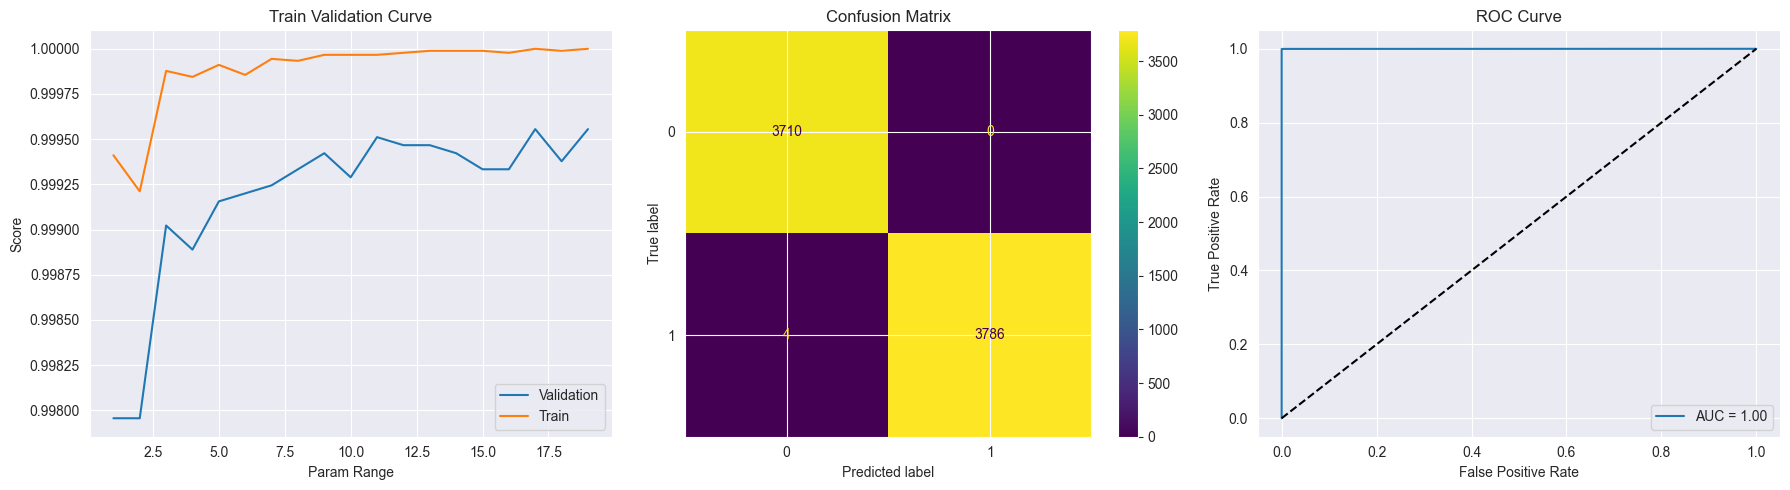

Best recall score:  0.9989445910290238
________________________________________________________________________________________________________________________________________________
Processing ------ Model :  LogisticRegression() -- Hyperparameters :  {'C': array([ 0.1       ,  0.62105263,  1.14210526,  1.66315789,  2.18421053,
        2.70526316,  3.22631579,  3.74736842,  4.26842105,  4.78947368,
        5.31052632,  5.83157895,  6.35263158,  6.87368421,  7.39473684,
        7.91578947,  8.43684211,  8.95789474,  9.47894737, 10.        ])} 



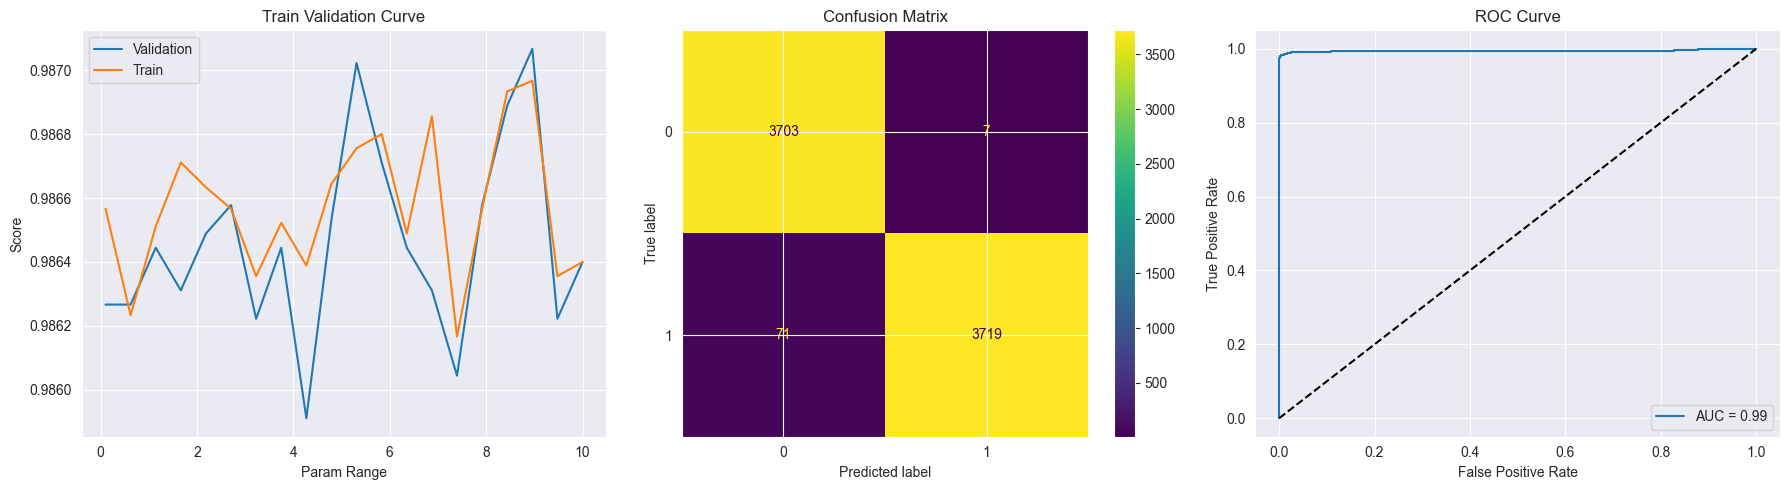

Best recall score:  0.9812664907651715
________________________________________________________________________________________________________________________________________________
Processing ------ Model :  HistGradientBoostingClassifier() -- Hyperparameters :  {'learning_rate': [0.01, 0.1, 0.2]} 



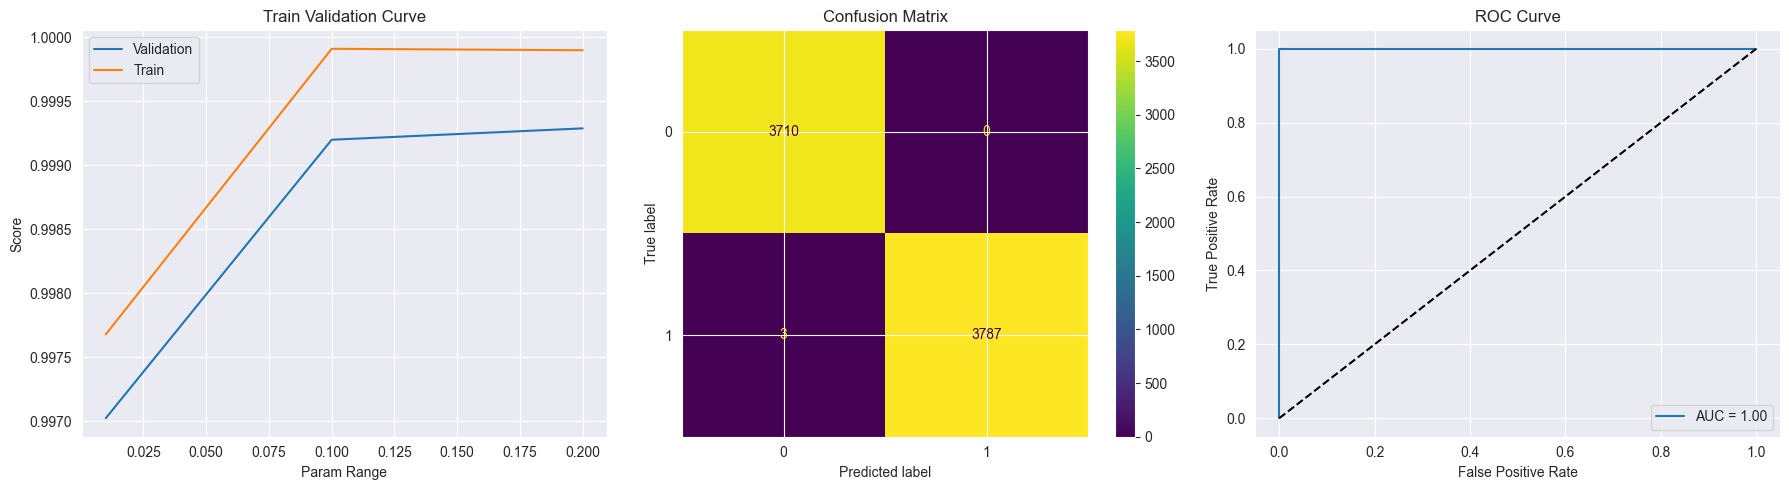

Best recall score:  0.9992084432717678
________________________________________________________________________________________________________________________________________________


In [12]:
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from automatisation import auto_supervised

# Liste de modèles
models = [
    RandomForestClassifier(),
    LogisticRegression(),
    HistGradientBoostingClassifier()  # Remplace GradientBoostingClassifier
]

hparam_list = [
    {'n_estimators': np.arange(1, 20)}, 
    {'C': np.linspace(0.1, 10, 20)},   
    {'learning_rate': [0.01, 0.1, 0.2]}
]
scoring_type = 'recall'
n_splits = 5
models = auto_supervised(models, X_train, X_test, y_train, y_test, hparam_list, n_splits, scoring_type)

In [13]:
for model in models:
    print("Méthode: ", model)
    print("Proportion d'anomalies prédites dans le dataset de test",np.round(np.mean(model.predict(X_test))*100,3), "%", "\n")


Méthode:  RandomForestClassifier(n_estimators=np.int64(9))
Proportion d'anomalies prédites dans le dataset de test 50.48 % 

Méthode:  LogisticRegression(C=np.float64(0.6210526315789474))
Proportion d'anomalies prédites dans le dataset de test 49.68 % 

Méthode:  HistGradientBoostingClassifier(learning_rate=0.2)
Proportion d'anomalies prédites dans le dataset de test 50.493 % 



Processing Model 1: IsolationForest() -- Hyperparameters: {'contamination': [0.01, 0.06444444444444444, 0.11888888888888888, 0.17333333333333334, 0.22777777777777777, 0.2822222222222222, 0.33666666666666667, 0.3911111111111111, 0.44555555555555554, 0.5]}
Best Hyperparameters: {'contamination': 0.06444444444444444}
Silhouette Score on Test: 0.07
Calinski-Harabasz Score on Test: 5.06
Best model IsolationForest(contamination=0.5)


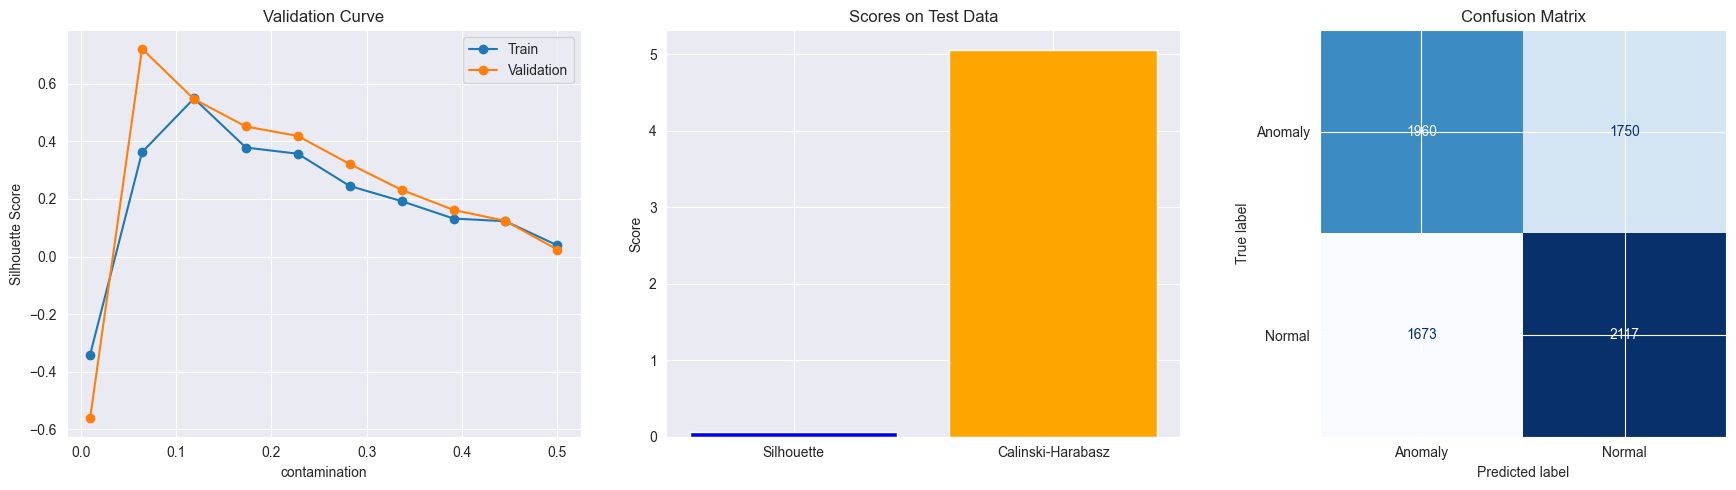

Processing Model 2: LocalOutlierFactor() -- Hyperparameters: {'n_neighbors': [5, 10, 20, 30], 'leaf_size': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48]}
Best Hyperparameters: {'n_neighbors': 5}
Silhouette Score on Test: 0.74
Calinski-Harabasz Score on Test: 80.79
Best model LocalOutlierFactor(n_neighbors=30)


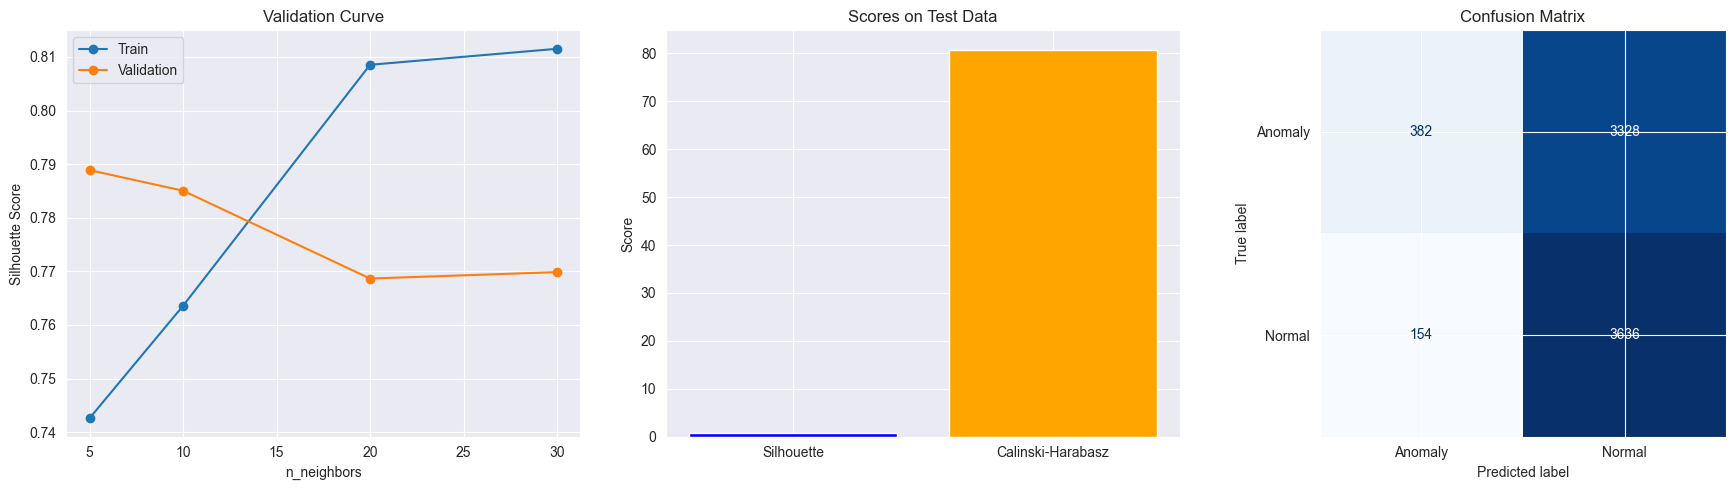

In [14]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from automatisation import auto_unsupervised

%matplotlib inline

models = [
    IsolationForest(),
    LocalOutlierFactor(),
]

hparam_list = [
    {'contamination': np.linspace(0.01,0.5,10).tolist()},
    {'n_neighbors': [5, 10, 20, 30], 'leaf_size': [2*i for i in range(5,25)]},  
]
models = auto_unsupervised(models, X_train, X_test, y_test, hparam_list)

Meilleurs modèles et hyperparamètres :

In [17]:
for model in models:
    print("Méthode: ", model)

Méthode:  IsolationForest(contamination=0.5)
Méthode:  LocalOutlierFactor(n_neighbors=30)
